# Fish Generator

The goal here is to make a GAN that can produce tropical looking fake fish

Going to attempt to grow the network progressively a la https://arxiv.org/pdf/1710.10196.pdf

## Exploring the data

In [1]:
import os
import sys

import numpy as np  
import pandas as pd 

import sklearn
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import glob
import imageio

import math
import random
import time
import datetime
import shutil
from tqdm import tqdm, tqdm_notebook


from dataclasses import dataclass
from pathlib import Path
import warnings
from scipy import linalg

import xml.etree.ElementTree as ET 

import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from IPython import display
from IPython.display import Image as IpyImage

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Layer

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Accuracy

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

from tensorflow.keras import backend as K

print(os.listdir("./"))


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


['fish_gan4_back_ep40.h5', 'fish_gan4_back_ep20.h5', '.DS_Store', 'GrabbedFromWeb', 'Loss', 'fish_gan_3.h5', 'FakeFish', 'fish_gan_2.h5', 'plot_line_plot_loss.png', 'ProcessedFish', 'Fish_discriminator_1.h5', 'h5s', 'FishGAN.ipynb', 'FishIMAGES.ipynb', 'FishGAN', 'GIFs', 'fish_gan_1.h5', 'fish_gan_5.h5', 'CustomFish', 'NewLabeledFish', 'FishWGAN.ipynb', '.ipynb_checkpoints', 'fish_gan6_back_ep20.h5', 'Fish_generator_1.h5', 'fish_gan6_back_ep40.h5', 'fish_gan2_back_ep120.h5', 'GrabbedFromWebBack']


In [2]:
#FishDIR='./ProcessedFish/'
FishDIR='./CustomFish/'
GenFishDIR='./FakeFish/'
GIFDIR = "./GIFs/"
h5DIR = './h5s/'

In [3]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(np.clip((image + 1.)/2.,0.,1.), cmap="binary")
        #plt.imshow(image, cmap="binary")
        plt.axis("off")

def read_image(src, RESIZE=None):
    img = cv2.imread(src)
    if img is None:
        print(src)
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if RESIZE is None:
        return img
    return img

def write_image(img,filename):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, img)

customOs={'LeakyReLU': LeakyReLU}

def constructGIF(ix,filename):
    gif_path = GIFDIR+filename+".gif"
    frames_path = GIFDIR+filename+"_{i}.jpg"
    with imageio.get_writer(gif_path, mode='I') as writer:
        for i in range(ix):
            writer.append_data(imageio.imread(frames_path.format(i=i)))

#IpyImage(filename=GIFDIR+modelname+"_test.gif")

def plot_history(d1_hist, d2_hist, g_hist):
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    #plt.savefig('./plot_line_plot_loss.png')
    #plt.close()
    
def plot_history(d_hist, g_hist):
    plt.plot(d_hist, label='crit')
    plt.plot(g_hist, label='gen')
    plt.legend()
    #plt.savefig('./plot_line_plot_loss.png')
    #plt.close()

In [4]:
# turns all arguments to to float32
def fp32(*values):
    if len(values) == 1 and isinstance(values[0], tuple):
        values = values[0]
    values = tuple(tf.cast(v, tf.float32) for v in values)
    return values if len(values) >= 2 else values[0]

# from 1710.10196 use mini batch standard dev on discriminator output (only needs to be done once)
# need to combine layers to fade out, inherit Add class
# fade parameter is updated in WGANGP class
class AddWithFade(Add):
    def __init__(self, fade=0.0, **kwargs):
        super(AddWithFade, self).__init__(**kwargs)
        # fade will increase linearly from 0-1 
        self.fade = K.variable(fade, name='fade_param')
 
    def _merge_function(self, inputs):
        assert (len(inputs) == 2)
        #input[0] = lower res layer, input[1] = higher res layer 
        output = ((1. - self.fade) * inputs[0]) + (self.fade * inputs[1])
        return output

# update the fade parameter in the model
def update_fade(model,newfade):
    for layer in model.layers:
        if isinstance(layer, AddWithFade):
            K.set_value(layer.fade,newfade)

# implementation of wasserstein loss with gradient penalty
# Useful information: https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
# keras implementation: https://keras.io/examples/generative/wgan_gp/
class WGANGP(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_steps=1,
        gp_weight=10.0,
        nMaxFade = 8000
    ):
        super(WGANGP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_steps
        self.gp_weight = gp_weight
        self.nMaxFade = nMaxFade
        self.fade = 0.0
        self.nRunFade = 0

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGANGP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images, withFade = True):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]
        
        # update the fade is model is being run with fade
        if withFade:
            if self.nRunFade == 0:
                self.nRunFade += int(batch_size/2)
            else:
                self.nRunFade += batch_size
            self.fade = min(self.nRunFade,self.nMaxFade)/self.nMaxFade
            update_fade(self.generator,self.fade)
            update_fade(self.discriminator,self.fade)

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [5]:
# this has the generator creating realistic deviations across batches
# this is likely more important for faces, etc
class MBStDev(Layer):
    def __init__(self, **kwargs):
        self.smallParam = 1e-8 
        super(MBStDev, self).__init__(**kwargs)
 
    # perform the operation
    def call(self, ins):
        # mean value for each pixel across channels
        pixMean = K.mean(ins, axis=0, keepdims=True)
        # standard deviation across each pixel coord (small param regulates singularity)
        stDev = K.sqrt(K.mean(K.square(ins - pixMean), axis=0, keepdims=True)+self.smallParam)
        # mean standard deviation across each pixel coord
        meanStDev = K.mean(stDev, keepdims=True)
        # scale this up to be the size of one input feature map for each sample
        shape = K.shape(ins)
        outs = K.tile(meanStDev, (shape[0], shape[1], shape[2], 1))
        # concatenate with the output
        joinedInandOut = K.concatenate([ins, outs], axis=-1)
        return joinedInandOut
 
    # corrects the output shape to match the joint values
    def correct_output_shape(self, input_shape):
        # create a copy of the input shape as a list
        input_shape = list(input_shape)
        # add one to the channel dimension (assume channels-last)
        input_shape[-1] += 1
        # convert list to a tuple
        return tuple(input_shape)

# from 1710.10196 - use pixel normalization, a variant of "local response normalization"
# Used to "disallow the scenario where the magnitudes in the generator and discriminator spiral out 
# of control as a result of competition" - apply BEFORE activation function in generator only
class PixelNorm(Layer):
    def __init__(self, **kwargs):
        self.smallParam = 1e-8 
        super(PixelNorm, self).__init__(**kwargs)
    
    def call(self, ins):
        # -1 is over the filters
        sqPixMean = K.mean(ins**2 + self.smallParam, axis=-1, keepdims=True)
        return ins / K.sqrt(sqPixMean)

In [6]:
# from https://keras.io/examples/generative/wgan_gp/
# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def critic_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    # 
    # this is a simple implementation of the drift loss
    epsilonDrift = 0.001
    epsilonLoss = epsilonDrift * tf.reduce_mean(tf.nn.l2_loss(real_img))
    return fake_loss - real_loss + epsilonLoss

# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Original implementation

In [ ]:
leveldict = {4: {'filters': 256},
             8: {'filters': 256},
            16: {'filters': 256},
            32: {'filters': 256},
            64: {'filters': 128},
            128: {'filters': 64}}

optimizercrit=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=1e-8)
optimizergen=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=1e-8)

# note: have not yet included section 4.1 EQUALIZED LEARNING RATE as implementing this is
#    a) something I am not certain how to do and b) potentially a solution very prone to errors
#    where I am doing something that would be replaced for that I've added a #4.1

# take from a model that criticises an nxnx3 figure to one that criticizes a 2nx2nx3 figure
def add_critic_level(old_c_model, new_level=8, nSkip=3,nSkipPassby=1,nColors=3):
    thisleveldict = leveldict[new_level]
    filters = thisleveldict['filters']
    conv2filters = leveldict[new_level/2]['filters']
    # #4.1 weight initialization and maxnorm constraint
    kinit = tf.keras.initializers.RandomNormal(stddev=0.02)
    kconstraint = None 
    
    #define new input layer
    layer_in = Input(shape=(new_level, new_level, nColors,)) 
    # new round start passby here
    conv_0 = Conv2D(filters, (1,1), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(layer_in)
    act_0 = LeakyReLU(alpha=0.2)(conv_0)
    # first layer set (newround start main model here)
    conv_1 = Conv2D(filters, (3,3), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_0)
    act_1 = LeakyReLU(alpha=0.2)(conv_1)
    # second layer set
    conv_2 = Conv2D(conv2filters, (3,3), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_1)
    act_2 = LeakyReLU(alpha=0.2)(conv_2)
    newcriticlayers = AveragePooling2D()(act_2)
    critic = newcriticlayers
    # append the earlier model
    for i in range(nSkip,len(old_c_model.layers)):
        critic = old_c_model.layers[i](critic)
    criticModel = Model(layer_in, critic)
    criticModel.compile(loss=critic_loss, optimizer=optimizercrit)
    
    # define passby model, first downsample
    pathtofade = AveragePooling2D()(layer_in)
    # note: including conv_0, and act_0 from previous layer
    for i in range(nSkipPassby,nSkip):
        pathtofade = old_c_model.layers[i](pathtofade)
    critic_fade = AddWithFade()([pathtofade,newcriticlayers])
    for i in range(nSkip,len(old_c_model.layers)):
        critic_fade = old_c_model.layers[i](critic_fade)
    criticFadeOut = Model(layer_in, critic_fade)
    criticFadeOut.compile(loss=critic_loss, optimizer=optimizercrit)
    return [criticModel, criticFadeOut]

# take from a model that generates an nxnx3 figure to one that generates a 2nx2nx3 figure
def add_generator_level(old_g_model, new_level=8, nDrop=3,nDropPassby=1,nColors=3):
    thisleveldict = leveldict[new_level]
    filters = thisleveldict['filters']
    # define input shape
    #new_model_in_shape =  [ new_level, new_level, n_input_layers]
    # #4.1 weight initialization and maxnorm constraint
    kinit = tf.keras.initializers.RandomNormal(stddev=0.02)
    kconstraint = None 
    
    # get input
    layer_in = old_g_model.input
    # remove final layer
    newendofold = old_g_model.layers[-2].output
    sizeaugment = UpSampling2D()(newendofold)
    
    # first layer set
    conv_1 = Conv2D(filters, (3,3), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(sizeaugment)
    pixnorm_1 = PixelNorm()(conv_1)
    act_1 = LeakyReLU(alpha=0.2)(pixnorm_1)
    # second layer set
    conv_2 = Conv2D(filters, (3,3), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_1)
    pixnorm_2 = PixelNorm()(conv_2)
    act_2 = LeakyReLU(alpha=0.2)(pixnorm_2)
    # save for combo below
    conv_out = Conv2D(nColors, (1,1), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_2)
    genModel = Model(layer_in, conv_out)
    
    # define passby model
    old_end = old_g_model.layers[-1].output
    sizeaugment_fade = UpSampling2D()(old_end)
    conv_out_fade = AddWithFade()([sizeaugment_fade,conv_out])
    
    genModelFade = Model(layer_in, conv_out_fade)
    
    return [genModel, genModelFade]

In [ ]:
# nLevels = number of pixelation levels (4,8,16,32,64,128) 
def create_critics(nColors=3, initialSize = 4, nLevels = 6):
    # first create the lowest level critic
    thisleveldict = leveldict[initialSize]
    filters = thisleveldict['filters']
    # #4.1 weight initialization and maxnorm constraint
    kinit = tf.keras.initializers.RandomNormal(stddev=0.02)
    kconstraint = None 
    #kconstraint = keras.constraints.max_norm(1.0)
    
    #define new input layer
    layer_in = Input(shape=(initialSize, initialSize, nColors,)) 
    # new round start passby here
    # define new input processing layer
    conv_0 = Conv2D(filters, (1,1), padding='SAME', kernel_initializer=kinit, kernel_constraint=kconstraint)(layer_in)
    act_0 = LeakyReLU(alpha=0.2)(conv_0)
    # first layer set (newround start main model here)
    # apply minibatch standard deviation
    miniBDev = MBStDev()(act_0)
    conv_1 = Conv2D(filters, (3,3), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(miniBDev)
    act_1 = LeakyReLU(alpha=0.2)(conv_1)
    # second layer set (the end is a 4x4 convolution)
    conv_2 = Conv2D(filters, (4,4), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_1)
    act_2 = LeakyReLU(alpha=0.2)(conv_2)
    dense_out = Flatten()(act_2)
    out_classifier = Dense(1)(dense_out)
    
    # define and compile model
    initial_critic = Model(layer_in,out_classifier)
    initial_critic.compile(loss=critic_loss, optimizer=optimizercrit)
    
    # collect all models
    modellist = [[initial_critic,initial_critic]]
    curlevel = 4
    for i in range(1,nLevels):
        curlevel = curlevel * 2
        # modellist[-1][0] corresponds to the version with no fade
        newmodels = add_critic_level(modellist[-1][0], new_level=curlevel)
        modellist.append(newmodels)
    return modellist


# nLevels = number of pixelation levels (4,8,16,32,64,128) 
def create_gens(nInputs =128, nColors=3, initialSize = 4, nLevels = 6):
    # first create the lowest level critic
    thisleveldict = leveldict[initialSize]
    filters = thisleveldict['filters']
    # #4.1 weight initialization and maxnorm constraint
    kinit = tf.keras.initializers.RandomNormal(stddev=0.02)
    kconstraint = None 
    
    #define new input layer
    layer_in = Input(shape=(nInputs,))
    dense_0 = Dense(nInputs*initialSize*initialSize, kernel_initializer=kinit, kernel_constraint=kconstraint)(layer_in)
    reshape_0 = Reshape((initialSize, initialSize, nInputs))(dense_0)
    #may want to add activiation functions
    # first layer set (start with 4x4)
    conv_1 = Conv2D(filters, (4,4), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(reshape_0)
    pixnorm_1 = PixelNorm()(conv_1)
    act_1 = LeakyReLU(alpha=0.2)(pixnorm_1)
    # second layer set
    conv_2 = Conv2D(filters, (3,3), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_1)
    pixnorm_2 = PixelNorm()(conv_2)
    act_2 = LeakyReLU(alpha=0.2)(pixnorm_2)
    # save for combo below
    conv_out = Conv2D(nColors, (1,1), padding="SAME", kernel_initializer=kinit, kernel_constraint=kconstraint)(act_2)
    genModel = Model(layer_in, conv_out)
    
        
    # collect all models
    modellist = [[genModel,genModel]]
    curlevel = 4
    for i in range(1,nLevels):
        curlevel = curlevel * 2
        # modellist[-1][0] corresponds to the version with no fade
        newmodels = add_generator_level(modellist[-1][0], new_level=curlevel)
        modellist.append(newmodels)
    return modellist

def create_gans(gens,crits,nInputs = 128):
    ganlist = []
    assert len(gens)==len(crits), "Generators and Discriminators created with different lengths"
    for i in range(len(gens)):
        # compile standard
        wgan1 = WGANGP(discriminator=crits[i][0],generator=gens[i][0],latent_dim=nInputs,discriminator_steps=1)
        wgan1.compile(d_optimizer=optimizercrit,g_optimizer=optimizergen,g_loss_fn=generator_loss,d_loss_fn=critic_loss)
        # compile fade
        wgan2 = WGANGP(discriminator=crits[i][1],generator=gens[i][1],latent_dim=nInputs,discriminator_steps=1)
        wgan2.compile(d_optimizer=optimizercrit,g_optimizer=optimizergen,g_loss_fn=generator_loss,d_loss_fn=critic_loss)
        # add to gan list
        ganlist.append([wgan1,wgan2])
    return ganlist
    

# ELR version

In [38]:
# this kernel implements equalized learning rate
# adapted from https://github.com/preritj/progressive_growing_of_GANs/blob/master/net.py
class Conv2DELR(Conv2D):
    """
    Standard Conv2D layer but includes learning rate equilization
    at runtime as per Karras et al. 2017.

    Inherits Conv2D layer and overrides the call method, following
    https://github.com/keras-team/keras/blob/master/keras/layers/convolutional.py

    """
    def __init__(self, *args, **kwargs):
        if 'kernel_initializer' in kwargs:
            raise Exception("Cannot override kernel_initializer")
        super().__init__(*args, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=1.), **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # The number of inputs
        n = np.product([int(val) for val in input_shape[1:]])
        # He initialisation constant
        self.c = np.sqrt(2/n)

    def call(self, inputs):
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel*self.c, # scale kernel
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [39]:
leveldict = {4: {'filters': 256},
             8: {'filters': 256},
            16: {'filters': 256},
            32: {'filters': 256},
            64: {'filters': 128},
            128: {'filters': 64}}

optimizercrit=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=1e-8)
optimizergen=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=1e-8)

# note: have not yet included section 4.1 EQUALIZED LEARNING RATE as implementing this is
#    a) something I am not certain how to do and b) potentially a solution very prone to errors
#    where I am doing something that would be replaced for that I've added a #4.1

# take from a model that criticises an nxnx3 figure to one that criticizes a 2nx2nx3 figure
def add_critic_level(old_c_model, new_level=8, nSkip=3,nSkipPassby=1,nColors=3):
    thisleveldict = leveldict[new_level]
    filters = thisleveldict['filters']
    conv2filters = leveldict[new_level/2]['filters']
    
    #define new input layer
    layer_in = Input(shape=(new_level, new_level, nColors,)) 
    # new round start passby here
    conv_0 = Conv2DELR(filters, (3,3), padding="SAME")(layer_in)
    act_0 = LeakyReLU(alpha=0.2)(conv_0)
    # first layer set (newround start main model here)
    conv_1 = Conv2DELR(filters, (3,3), padding="SAME")(act_0)
    act_1 = LeakyReLU(alpha=0.2)(conv_1)
    # second layer set
    conv_2 = Conv2DELR(conv2filters, (3,3), padding="SAME")(act_1)
    act_2 = LeakyReLU(alpha=0.2)(conv_2)
    newcriticlayers = AveragePooling2D()(act_2)
    critic = newcriticlayers
    # append the earlier model
    for i in range(nSkip,len(old_c_model.layers)):
        critic = old_c_model.layers[i](critic)
    criticModel = Model(layer_in, critic)
    
    # define passby model, first downsample
    pathtofade = AveragePooling2D()(layer_in)
    # note: including conv_0, and act_0 from previous layer
    for i in range(nSkipPassby,nSkip):
        pathtofade = old_c_model.layers[i](pathtofade)
    critic_fade = AddWithFade()([pathtofade,newcriticlayers])
    for i in range(nSkip,len(old_c_model.layers)):
        critic_fade = old_c_model.layers[i](critic_fade)
    criticFadeOut = Model(layer_in, critic_fade)
    return [criticModel, criticFadeOut]

# take from a model that generates an nxnx3 figure to one that generates a 2nx2nx3 figure
def add_generator_level(old_g_model, new_level=8, nDrop=3,nDropPassby=1,nColors=3):
    thisleveldict = leveldict[new_level]
    filters = thisleveldict['filters']
    
    # get input
    layer_in = old_g_model.input
    # remove final layer
    newendofold = old_g_model.layers[-2].output
    sizeaugment = UpSampling2D()(newendofold)
    
    # first layer set
    conv_1 = Conv2DELR(filters, (3,3), padding="SAME")(sizeaugment)
    pixnorm_1 = PixelNorm()(conv_1)
    act_1 = LeakyReLU(alpha=0.2)(pixnorm_1)
    # second layer set
    conv_2 = Conv2DELR(filters, (3,3), padding="SAME")(act_1)
    pixnorm_2 = PixelNorm()(conv_2)
    act_2 = LeakyReLU(alpha=0.2)(pixnorm_2)
    # save for combo below
    conv_out = Conv2DELR(nColors, (1,1), padding="SAME")(act_2)
    genModel = Model(layer_in, conv_out)
    
    # define passby model
    old_end = old_g_model.layers[-1].output
    sizeaugment_fade = UpSampling2D()(old_end)
    conv_out_fade = AddWithFade()([sizeaugment_fade,conv_out])
    
    genModelFade = Model(layer_in, conv_out_fade)
    
    return [genModel, genModelFade]

In [40]:
# nLevels = number of pixelation levels (4,8,16,32,64,128) 
def create_critics(nColors=3, initialSize = 4, nLevels = 6):
    # first create the lowest level critic
    thisleveldict = leveldict[initialSize]
    filters = thisleveldict['filters']
    
    #define new input layer
    layer_in = Input(shape=(initialSize, initialSize, nColors,)) 
    # new round start passby here
    # define new input processing layer
    conv_0 = Conv2DELR(filters, (1,1), padding="SAME")(layer_in)
    act_0 = LeakyReLU(alpha=0.2)(conv_0)
    # first layer set (newround start main model here)
    # apply minibatch standard deviation
    miniBDev = MBStDev()(act_0)
    conv_1 = Conv2DELR(filters, (3,3), padding="SAME")(miniBDev)
    act_1 = LeakyReLU(alpha=0.2)(conv_1)
    # second layer set (the end is a 4x4 convolution)
    conv_2 = Conv2DELR(filters, (4,4), padding="SAME")(act_1)
    act_2 = LeakyReLU(alpha=0.2)(conv_2)
    dense_out = Flatten()(act_2)
    out_classifier = Dense(1)(dense_out)
    
    # define and compile model
    initial_critic = Model(layer_in,out_classifier)
    
    # collect all models
    modellist = [[initial_critic,initial_critic]]
    curlevel = 4
    for i in range(1,nLevels):
        curlevel = curlevel * 2
        # modellist[-1][0] corresponds to the version with no fade
        newmodels = add_critic_level(modellist[-1][0], new_level=curlevel)
        modellist.append(newmodels)
    return modellist


# nLevels = number of pixelation levels (4,8,16,32,64,128) 
def create_gens(nInputs =128, nColors=3, initialSize = 4, nLevels = 6):
    # first create the lowest level critic
    thisleveldict = leveldict[initialSize]
    filters = thisleveldict['filters']
    # #4.1 weight initialization and maxnorm constraint
    kinit = tf.keras.initializers.RandomNormal(stddev=1.)
    
    #define new input layer
    layer_in = Input(shape=(nInputs,))
    dense_0 = Dense(nInputs*initialSize*initialSize, kernel_initializer=kinit)(layer_in)
    reshape_0 = Reshape((initialSize, initialSize, nInputs))(dense_0)
    #may want to add activiation functions
    # first layer set (start with 4x4)
    conv_1 = Conv2DELR(filters, (4,4), padding="SAME")(reshape_0)
    pixnorm_1 = PixelNorm()(conv_1)
    act_1 = LeakyReLU(alpha=0.2)(pixnorm_1)
    # second layer set 
    conv_2 = Conv2DELR(filters, (3,3), padding="SAME")(act_1)
    pixnorm_2 = PixelNorm()(conv_2)
    act_2 = LeakyReLU(alpha=0.2)(pixnorm_2)
    # save for combo below
    conv_out = Conv2DELR(nColors, (1,1), padding="SAME")(act_2)
    genModel = Model(layer_in, conv_out)
    
        
    # collect all models
    modellist = [[genModel,genModel]]
    curlevel = 4
    for i in range(1,nLevels):
        curlevel = curlevel * 2
        # modellist[-1][0] corresponds to the version with no fade
        newmodels = add_generator_level(modellist[-1][0], new_level=curlevel)
        modellist.append(newmodels)
    return modellist

def create_gans(gens,crits,nInputs = 128):
    ganlist = []
    assert len(gens)==len(crits), "Generators and Discriminators created with different lengths"
    for i in range(len(gens)):
        # compile standard
        wgan1 = WGANGP(discriminator=crits[i][0],generator=gens[i][0],latent_dim=nInputs,discriminator_steps=1)
        wgan1.compile(d_optimizer=optimizercrit,g_optimizer=optimizergen,g_loss_fn=generator_loss,d_loss_fn=critic_loss)
        # compile fade
        wgan2 = WGANGP(discriminator=crits[i][1],generator=gens[i][1],latent_dim=nInputs,discriminator_steps=1)
        wgan2.compile(d_optimizer=optimizercrit,g_optimizer=optimizergen,g_loss_fn=generator_loss,d_loss_fn=critic_loss)
        # add to gan list
        ganlist.append([wgan1,wgan2])
    return ganlist
    

# Training Setup

In [41]:
# Image processing
datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.05,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=[0.95,1.1],
        brightness_range=[0.8,1.3],
        horizontal_flip=True,
        fill_mode='nearest')

# adjust the saturation of the image
def colorSaturationAdjust(img, satRange=[0.6,1.4]):
    rSat = random.triangular(satRange[0],satRange[1])
    gSat = random.triangular(satRange[0],satRange[1])
    bSat = random.triangular(satRange[0],satRange[1])
    satVar = [rSat, gSat, bSat]
    return np.clip(img * satVar,0,1)

def multiprocessingI(imglist):
    imglistproc = []
    for img in datagen.flow((imglist+1.)/2.000)[0]:
        imglistproc.append(np.clip(2.*(colorSaturationAdjust(img/255.0)-0.5),-1.,1.))
        #imglistproc.append(colorSaturationAdjust(img/255.0))
    return np.asarray(imglistproc)

def multiprocessingI(imglist,new_length):
    imglistproc = []
    for img in datagen.flow((imglist+1.)/2.000)[0]:
        newimg = np.clip(2.*(colorSaturationAdjust(img/255.0)-0.5),-1.,1.)
        imglistproc.append(cv2.resize(newimg, (new_length,new_length), interpolation = cv2.INTER_AREA))
        #imglistproc.append(colorSaturationAdjust(img/255.0))
    return np.asarray(imglistproc)

In [42]:
# create models
genlist = create_gens()
criticlist = create_critics()
ganlist = create_gans(genlist,criticlist)

In [43]:
FishFiles = os.listdir(FishDIR)
# reshape and rescale into a numpy array
Xtrain = np.stack([ read_image(FishDIR+i) * np.float32(2. / 255.) - 1  for i in FishFiles ])

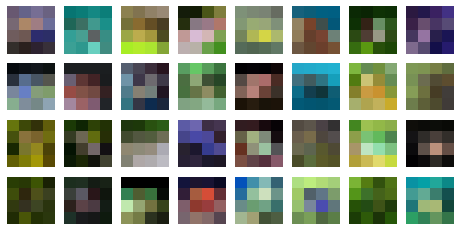

In [44]:
plot_multiple_images(multiprocessingI(Xtrain[:32],4),8)

In [45]:
#for GIF
batch_size = 32
codings_size = 128
fixednoise = tf.random.normal(shape=[batch_size, codings_size])
imgsetforGIF = []

dataset = tf.data.Dataset.from_tensor_slices(Xtrain)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [46]:
d_loss_hist, g_loss_hist = list(), list()

def train_wgan(wgan, dataset, batch_size, codings_size, image_size, n_epochs=10):
    generator = wgan.generator
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))  
        d_loss, g_loss = 0, 0
        starttime = time.time()
        for X_batch in dataset:
            lossdict = wgan.train_step(multiprocessingI(X_batch,image_size))
            d_loss += lossdict['d_loss']
            g_loss += lossdict['g_loss']
        if epoch % 3 == 0 or epoch+1 == n_epochs: 
            generated_images = generator(fixednoise)
            imgsetforGIF.append(generated_images)
            plot_multiple_images(generated_images, 8)
            plt.show()                                        
        d_loss_hist.append(d_loss)
        g_loss_hist.append(g_loss)
        print('Epoch took {time:.3f} seconds: d_loss={dl:.3f},  g_loss={gl:.3f}'.format(time=time.time() - starttime, dl = d_loss, gl = g_loss))

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



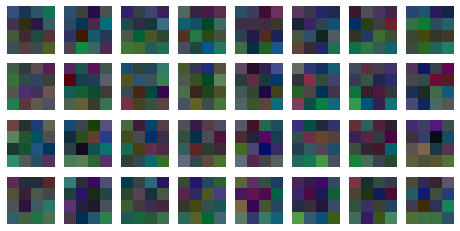

Epoch took 75.967 seconds: d_loss=31.777,  g_loss=-2.998
Epoch 2/20
Epoch took 73.455 seconds: d_loss=-10.914,  g_loss=-10.991
Epoch 3/20
Epoch took 74.577 seconds: d_loss=-13.632,  g_loss=0.171
Epoch 4/20


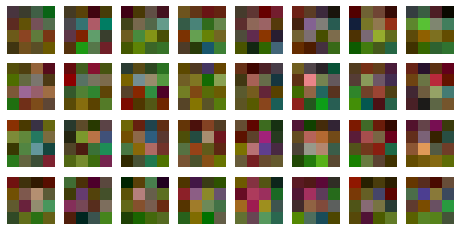

Epoch took 75.996 seconds: d_loss=-16.183,  g_loss=19.391
Epoch 5/20
Epoch took 73.226 seconds: d_loss=-24.256,  g_loss=31.354
Epoch 6/20
Epoch took 72.593 seconds: d_loss=-21.541,  g_loss=21.442
Epoch 7/20


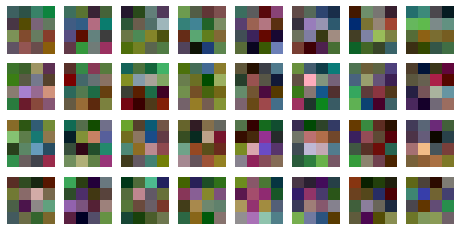

Epoch took 73.522 seconds: d_loss=-17.322,  g_loss=27.330
Epoch 8/20
Epoch took 74.602 seconds: d_loss=-15.614,  g_loss=27.809
Epoch 9/20
Epoch took 73.222 seconds: d_loss=-14.814,  g_loss=28.918
Epoch 10/20


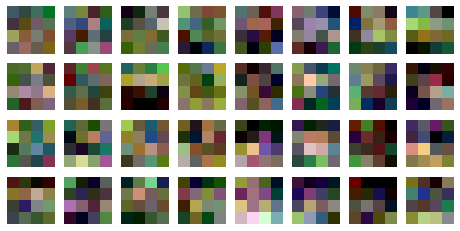

Epoch took 73.761 seconds: d_loss=-17.116,  g_loss=33.441
Epoch 11/20


In [ ]:
train_wgan(ganlist[0][1], dataset, batch_size, codings_size, 4, n_epochs=20)

In [ ]:
train_wgan(ganlist[1][1], dataset, batch_size, codings_size, 8, n_epochs=20)

In [ ]:
train_wgan(ganlist[2][1], dataset, batch_size, codings_size, 16, n_epochs=20)

In [ ]:
plot_history(d_loss_hist,g_loss_hist)

# Saving and loading

In [ ]:
#save gan to files
filename = './fish_gan_1.h5'
gan.save(filename)

In [ ]:
frames_path = GIFDIR+"gan1_{i}.jpg"
for i, imgs in enumerate(imgsetforGIF):
    plot_multiple_images(imgs, 8)
    plt.savefig(frames_path.format(i=i))
constructGIF(len(imgsetforGIF),"gan1")
display.clear_output()
#IpyImage(filename=GIFDIR+"gan1.gif")

In [ ]:
#IpyImage(filename=GIFDIR+"gan1.gif")

In [ ]:
# load model
gan = load_model('./fish_gan_1.h5',custom_objects=customOs)
generator, discriminator = gan.layers

codings_size = 100
batch_size = 32

# Simple assessment of proximal images

In [ ]:
def imageDistance(im1,im2):
    dist = 0
    if len(im1) != len(im2) or len(im1[0]) != len(im2[0]) or len(im1[0][0]) != len(im2[0][0]):
        print("Images are not the same size")
        return 255. * len(im1) * len(im1[0])* len(im1[0][0])
    imx = im1 - im2
    return float(tf.math.reduce_sum(imx*imx))**0.5

def findClosestImage(genimg,imgset):
    distSet = False
    bestdist = 10**20
    for img in imgset:
        curdist = imageDistance(genimg, img)
        if curdist < bestdist or not distSet:
            bestdist = curdist
            bestimg = img
            distSet = True
    return bestimg

In [ ]:
noise = tf.random.normal(shape=[batch_size, 100])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

In [ ]:
imID = 1
plt.imshow((generated_images[imID]+1)/2)                
plt.show()

In [ ]:
closestim = findClosestImage(generated_images[imID],Xtrain)
plt.imshow((closestim+1)/2)                
plt.show()